In [188]:
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from skopt import BayesSearchCV
from sklearn.metrics import r2_score, mean_absolute_error
from skopt.callbacks import DeltaYStopper
from skopt.space import Real, Categorical, Integer
import json
from xgboost import XGBClassifier

In [175]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ggray15/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [176]:
def Blob2Words(TextBlob):
    TextBlob = TextBlob.split(' ')
    words = [w for w in TextBlob if w.isalpha()]
    stopwords = nltk.corpus.stopwords.words('english')
    stopwords.remove('not')
    words = [w for w in words if w.lower() not in stopwords]
    return words

def remove_stopwords(word_list):
    filtered_list = list()
    stop_words = nltk.corpus.stopwords.words('english')
    for word in word_list:
        if word.casefold() not in stop_words:
            filtered_list.append(word.lower())
    return filtered_list

def stem_words(word_list):
    filtered_list = list()
    stemmer = PorterStemmer()
    for word in word_list:
        filtered_list.append(stemmer.stem(word))
    return filtered_list

In [177]:
RootDir = '/Users/ggray15/src/python/repos/jhach_cpdsam_symposium_workshop'
os.chdir(RootDir)

In [217]:
%run "./notebooks/function_library.ipynb"

In [179]:
input_df = pd.read_csv('data/notes_labeled.csv')
input_df

,hadm_id,text,readmit_flag
0,100025,1 Fluid and Nutrition\n2 Alt in Parenting\n3 A...,0
1,100029,NPN [**6-/2082**]\n\n\n\n #3 [**Doctor First N...,0
2,100044,Neonatology Attending\nDay 31\nPCA 39 5\n\nRA....,0
3,100062,NURSING PROGRESS NOTE\n\n\n2 - FEN - BABY BREA...,0
4,100079,Admission Note\nOB- [**First Name8 (NamePatter...,0
...,...,...,...
4479,199901,Neonatology\nDoing well. REmains in RA. No spe...,0
4480,199913,"NPN 07a-07p\n\n\nFEN\nTF 150cc/kg/day, BM/Neos...",0
4481,199917,Nursing Progress Note\n\n\n#1-O/A- Received i...,0
4482,199918,"PCA Note:\n\n\nResp: O: Infant in RA, SaO2 wit...",0


In [180]:
input_df['text_tokenized'] = input_df['text'].apply(lambda x: Blob2Words(x))
input_df['text_remove_stop'] = input_df['text_tokenized'].apply(lambda x: remove_stopwords(x))
input_df['text_stem'] = input_df['text_remove_stop'].apply(lambda x: stem_words(x))
input_df['text_cleaned'] = input_df['text_stem'] .apply(lambda x: ' '.join(x)) 
input_df

,hadm_id,text,readmit_flag,text_tokenized,text_remove_stop,text_stem,text_cleaned
0,100025,1 Fluid and Nutrition\n2 Alt in Parenting\n3 A...,0,"[Fluid, Alt, Alt, Fluid, Start, Alt, Start, Al...","[fluid, alt, alt, fluid, start, alt, start, al...","[fluid, alt, alt, fluid, start, alt, start, al...",fluid alt alt fluid start alt start alt start ...
1,100029,NPN [**6-/2082**]\n\n\n\n #3 [**Doctor First N...,0,"[NPN, First, Name, CHANGED, MIN, TAKING, BOTTL...","[npn, first, name, changed, min, taking, bottl...","[npn, first, name, chang, min, take, bottl, ab...",npn first name chang min take bottl abd soft s...
2,100044,Neonatology Attending\nDay 31\nPCA 39 5\n\nRA....,0,"[Neonatology, Cl, days, HR, BP, Wt, PO, ad, li...","[neonatology, cl, days, hr, bp, wt, po, ad, li...","[neonatolog, cl, day, hr, bp, wt, po, ad, lib,...",neonatolog cl day hr bp wt po ad lib tol nl vo...
3,100062,NURSING PROGRESS NOTE\n\n\n2 - FEN - BABY BREA...,0,"[NURSING, PROGRESS, FEN, BABY, BREAST, FEEDING...","[nursing, progress, fen, baby, breast, feeding...","[nurs, progress, fen, babi, breast, feed, ad, ...",nurs progress fen babi breast feed ad lib abd ...
4,100079,Admission Note\nOB- [**First Name8 (NamePatter...,0,"[Admission, Name, see, baby, boy, sepsis, gram...","[admission, name, see, baby, boy, sepsis, gram...","[admiss, name, see, babi, boy, sepsi, gram, pr...",admiss name see babi boy sepsi gram product te...
...,...,...,...,...,...,...,...
4479,199901,Neonatology\nDoing well. REmains in RA. No spe...,0,"[REmains, Comfortable, Tolerating, feeds, Abdo...","[remains, comfortable, tolerating, feeds, abdo...","[remain, comfort, toler, feed, abdomend, take,...",remain comfort toler feed abdomend take ad lib...
4480,199913,"NPN 07a-07p\n\n\nFEN\nTF 150cc/kg/day, BM/Neos...",0,"[NPN, Tolerating, Bottled, shift, thus, end, B...","[npn, tolerating, bottled, shift, thus, end, b...","[npn, toler, bottl, shift, thu, end, bs, stool...",npn toler bottl shift thu end bs stool shift t...
4481,199917,Nursing Progress Note\n\n\n#1-O/A- Received i...,0,"[Nursing, Progress, Received, infant, Tried, i...","[nursing, progress, received, infant, tried, i...","[nurs, progress, receiv, infant, tri, infant, ...",nurs progress receiv infant tri infant sat con...
4482,199918,"PCA Note:\n\n\nResp: O: Infant in RA, SaO2 wit...",0,"[PCA, Infant, within, limits, mild, SC, spells...","[pca, infant, within, limits, mild, sc, spells...","[pca, infant, within, limit, mild, sc, spell, ...",pca infant within limit mild sc spell thu infa...


In [181]:
train_df, test_df = train_test_split(input_df[['text_cleaned','readmit_flag']],test_size=0.4,random_state=42, stratify=input_df['readmit_flag'].tolist())

In [182]:
vectorizer = TfidfVectorizer(min_df = 3, stop_words="english", sublinear_tf=True, norm='l2', ngram_range=(1, 2))
feature_selector = SelectKBest(chi2, k=1200)
#model = MLPClassifier(max_iter=1000)
model = GradientBoostingClassifier()

In [183]:
param_files = [
    'lr_params.json',
    'knn_params.json',
    'svm_params.json',
    'mlp_params.json',
    'rf_params.json',
    'gb_params.json',
]

param_dict = dict()

for iFile in param_files:
    iKey = iFile.split('_')[0]
    with open(os.path.join('input',iFile),'r') as f:
        params = json.load(f)
        param_dict_temp = BuildSamplingDict(params)
        
        param_dict[iKey] = dict()
        for jKey in param_dict_temp:
            param_dict[iKey]['est__'+jKey] = param_dict_temp[jKey]
        

In [184]:
estimator_dict = {
    'lr': LogisticRegression(max_iter=1000),
    'knn': KNeighborsClassifier(algorithm='auto'),
    'svm': SVC(probability=True),
    'mlp': MLPClassifier(max_iter=1000),
    'rf': RandomForestClassifier(),
    'gb': GradientBoostingClassifier()
}

In [185]:
pipeline_dict = {}

for iKey in estimator_dict:

    pipeline = Pipeline(
        [
            ('tfidf', vectorizer),
            ('feature_selector', feature_selector),
            ('est', estimator_dict[iKey])
        ]
    )

    pipeline_dict[iKey] = pipeline

In [186]:
model_dict = dict()

for iKey in estimator_dict:

    if iKey == 'knn':
        continue

    print(f'##### Now processing model {iKey} #####')

    model_dict[iKey] = TuneHyperParameters(
        X_train=train_df['text_cleaned'], y_train=train_df['readmit_flag'], estimator= pipeline_dict[iKey],param_dict=param_dict[iKey])
    
    test_score = EvaluateModel(X_test=test_df['text_cleaned'],y_test=test_df['readmit_flag'],estimator=model_dict[iKey])
    print(f'  > Test score was {test_score}')   

##### Now processing model lr #####
  > Test score was 0.0
##### Now processing model svm #####
  > Test score was 0.0
##### Now processing model mlp #####


KeyboardInterrupt: 

In [ ]:
for iKey in model_dict:

    print(f'##### Now processing model {iKey} #####')
    LogMetrics(model_dict[iKey],test_df['text_cleaned'], test_df['readmit_flag'])

In [229]:
with open('input/xgb_params.json','r') as f:
    param_dict = json.load(f)

pipeline_param_dict = dict()
for iKey in param_dict:
    pipeline_param_dict['est__'+iKey] = param_dict[iKey]

pipeline_param_dict = BuildSamplingDict(pipeline_param_dict)

In [230]:
pipeline = Pipeline(
    [
        ('tfidf', vectorizer),
        ('feature_selector', feature_selector),
        ('est', XGBClassifier())
    ]
)


In [231]:
xgb_opt = TuneHyperParameters(
    X_train=train_df['text_cleaned'], y_train=train_df['readmit_flag'], estimator=pipeline, param_dict=pipeline_param_dict, metric='f1', n_iter=100)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/Users/ggray15/opt/anaconda3/envs/py310_datascience/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ggray15/opt/anaconda3/envs/py310_datascience/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ggray15/opt/anaconda3/envs/py310_datascience/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetric

Accuracy: 0.9760312151616499
F1 Score: 0.0
AUC: 0.6272960301754479
Precision: 0.0
Recall: 0.0
logloss: 0.863922572871816
PPV: nan
NPV: 0.9760312151616499
True Negative: 1751
False Positive: 0
False Negative: 43
True Positive: 0


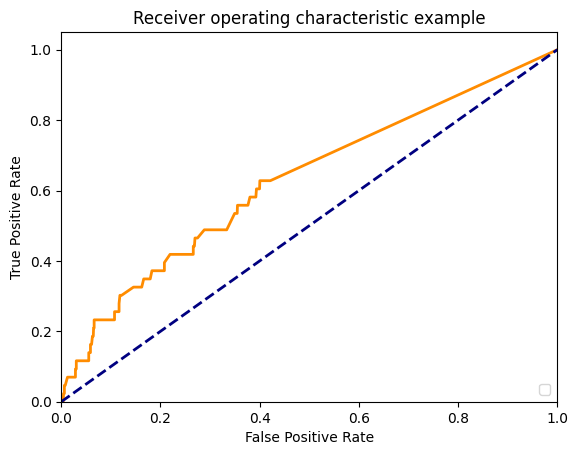

In [232]:
LogMetrics(xgb_opt, test_df['text_cleaned'], test_df['readmit_flag'])